# Plotting maps

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import healpy as hp
from matplotlib.projections.geo import GeoAxes
import skymapper as skm
import pyfits as pf 
import numpy as np
from copy import copy
import pyfits as pf
from matplotlib.projections.geo import GeoAxes
import pyfits as pf 
from copy import copy

def plot_map(mapa, lonra, latra, res, vmin = None, vmax = None, title = None, x_len = 10, y_len = 3):
    class ThetaFormatterShiftPi(GeoAxes.ThetaFormatter):
        """Shifts labelling by pi
        Shifts labelling from -180,180 to 0-360"""
        def __call__(self, x, pos=None):
            if x != 0:
                x *= -1
            if x < 0:
                x += 2*np.pi
            return GeoAxes.ThetaFormatter.__call__(self, x, pos)

    mute2=mapa

#test = hp.cartview(mute2, lonra=[-38, -10], latra=[-2.5, 2.5], cbar = True, notext= False)

    nside = hp.pixelfunc.npix2nside(len(mapa))
    
    XSIZE = np.int((max(lonra)-min(lonra))/(res/60.))
    YSIZE = np.int((max(latra)-min(latra))/(res/60.))
   
    ra = np.linspace(lonra[0], lonra[1], XSIZE)
    dec   = np.linspace(latra[0], latra[1], YSIZE)



# project the map to a rectangular matrix xsize x ysize
    ra , dec = np.meshgrid(ra, dec)
    grid_pix = hp.pixelfunc.ang2pix(nside, np.radians(-dec+90.), np.radians(ra),nest=False)



    fig = plt.figure(figsize=(x_len,y_len))

#ax = fig.add_subplot(111,projection='mollweide')
    ax = fig.add_subplot(111)
    
    palette = copy(plt.cm.bwr)
    #palette.set_over('r', 1.0)
    #palette.set_under('g', 1.0)
    palette.set_bad('grey', 1.0)
    #cmap1.set_bad('grey') 

    image = plt.pcolormesh(ra, dec, mute2[grid_pix], rasterized=True, cmap = palette , vmin = vmin, vmax = vmax)




    # colorbar
    cb = fig.colorbar(image, orientation='vertical', shrink=.6, pad=0.05)
    cb.ax.xaxis.labelpad = -8
    # workaround for issue with viewers, see colorbar docstring
    cb.solids.set_edgecolor("face")

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    if title:
        plt.title(title)
    # remove white space around figure
    spacing = 0.01
    plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)

    plt.grid(True)
    
def skm_plot(mapa, sep=15):
    nside = hp.pixelfunc.npix2nside(len(mapa))
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111, aspect='equal')

    fig, ax, proj = skm.plotHealpix(mapa, nside, sep=sep, ax=ax)


    # make free-form map (only works for equal-area projections)
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111, aspect='equal')
    
    pixels = np.flatnonzero(m)
    ra_, dec_ = getHealpixCoords(pixels, nside)
    fig, ax, proj = skm.plotMap(ra_, dec_, m[pixels], sep=sep, ax=ax, cmap='YlOrRd', cb_label="Map value")


# Load clusters

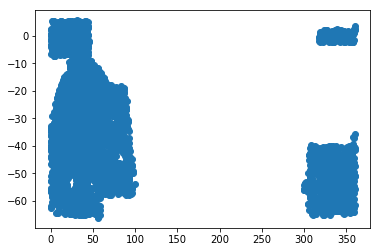

In [4]:
redmapper=pf.open('../input_files/y3_gold_1.0_wide_cmv02a_cmcm2_run_redmapper_v6.4.20_lgt20_vl50_catalog.fit')

z_red = redmapper[1].data['Z_LAMBDA']
ra_red = redmapper[1].data['RA']
dec_red = redmapper[1].data['DEC']
rich_red = redmapper[1].data['LAMBDA_CHISQ']
mask_red = (z_red > 0.2) & (z_red < 0.5) & (rich_red > 30.)
ra_red=ra_red[mask_red]
dec_red = dec_red[mask_red]
plt.scatter(ra_red,dec_red)

# Read maps

In [6]:
# inputs ********************
file_path = 'test_map_bigger_0.6_1.2.fits'
info_path = 'test_map_bigger_0.6_1.2_info.npz'
mask_path = '../output_files/test_map_bigger_MASK_0.6_1.2.fits'
sigma_smooth = 30 # in arcmin

lonra = [0, 20]
latra = [-70, -10]

res_map = 10 # in arcmin, after smoothing


# load info and estimate noise properties
info = np.load(info_path)
ngal = info['ngal']
e1_std = info['e1_std']
e2_std = info['e2_std']
area = info['area']
density = ngal/(area*60*60.)

noise = np.sqrt( (e1_std * e1_std + e2_std * e2_std) / ( 4.* np.pi * sigma_smooth * sigma_smooth * density))


# reading the mask ******************************************
import pyfits as pf
mute=pf.open(mask_path)
mask=mute[1].data['MASK']
mask = mask == 0.



field = 'kE'
# reading the map *******************************************
mapa = pf.open(file_path)
vars()['{0}'.format(field)] = mapa[1].data[field]

# smoothing *************************************************
if sigma_smooth == None:
    pass
else:
    sigma_smooth1 = (sigma_smooth/60.)*np.pi/180.
    vars()['{0}'.format(field)] = hp.sphtfunc.smoothing(vars()['{0}'.format(field)], sigma = sigma_smooth1)

field = 'kB'
# reading the map *******************************************
mapa = pf.open(file_path)
vars()['{0}'.format(field)] = mapa[1].data[field]

# smoothing *************************************************
if sigma_smooth == None:
    pass
else:
    sigma_smooth1 = (sigma_smooth/60.)*np.pi/180.
    vars()['{0}'.format(field)] = hp.sphtfunc.smoothing(vars()['{0}'.format(field)], sigma = sigma_smooth1)
    

Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


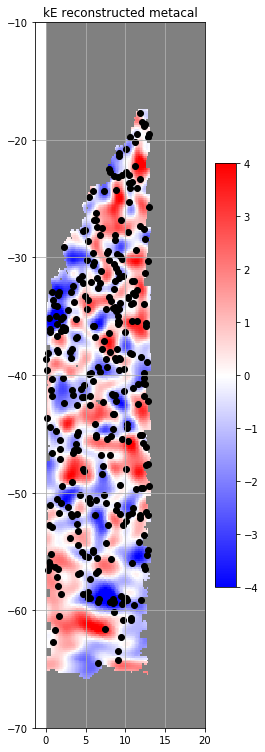

In [14]:
# plotting **************************************************
 
mask_RM = (ra_red < 13 ) & (dec_red < -10)
field = 'kE'
vars()['{0}'.format(field)] = np.ma.masked_where(mask, vars()['{0}'.format(field)])
plot_map(vars()['{0}'.format(field)]/noise, lonra, latra, res_map, x_len =3, y_len= 10, vmin = -4, vmax = 4, title = 'kE reconstructed metacal')
plt.scatter(ra_red[mask_RM],dec_red[mask_RM], color ='black')

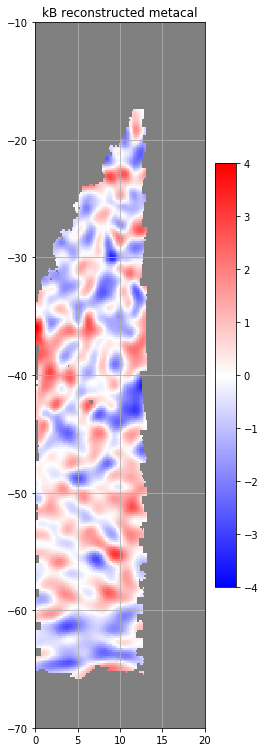

In [15]:
field = 'kB'
vars()['{0}'.format(field)] = np.ma.masked_where(mask, vars()['{0}'.format(field)])
plot_map(vars()['{0}'.format(field)]/noise, lonra, latra, res_map, x_len =3, y_len= 10, vmin = -4, vmax = 4, title = 'kB reconstructed metacal')


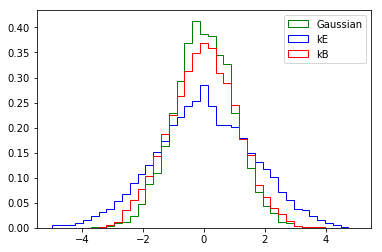

In [16]:
# plot S/N histogram
steps = 40
plt.hist(np.random.normal(0, 1., 3000), bins = np.linspace(-5,5,steps), normed = True,  color = 'green', histtype = 'step', label = 'Gaussian')
plt.hist(vars()['{0}'.format('kE')][~mask]/noise, bins = np.linspace(-5,5,steps), normed = True,  color = 'blue', histtype = 'step', label = 'kE')
plt.hist(vars()['{0}'.format('kB')][~mask]/noise, bins = np.linspace(-5,5,steps), normed = True, color = 'red', histtype = 'step', label = 'kB')
plt.legend()